# Inject data into PostgreSQL

In [34]:
import pandas as pd
from sqlalchemy import create_engine

# PostgreSQL connection details
db_user = 'postgres'
db_password = 'admin'
db_host = 'localhost'  # or remote host
db_port = '5433'
db_name = 'myDatabase'

# Create connection string
engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

# Read CSV files
energy_df = pd.read_csv("Energy_Usage_Dataset.csv")
performance_df = pd.read_csv("Server_Performance_Dataset.csv")
vendor_df = pd.read_csv("Vendor_Dataset.csv")

# Optional cleaning (e.g., rename columns to match SQL standards)
#energy_df.columns = [col.strip().lower().replace(" ", "_").replace("(", "").replace(")", "") for col in energy_df.columns]
#performance_df.columns = [col.strip().lower().replace(" ", "_").replace("(", "").replace(")", "") for col in performance_df.columns]
#vendor_df.columns = [col.strip().lower().replace(" ", "_").replace("(", "").replace(")", "") for col in vendor_df.columns]

# Load to PostgreSQL (replace if exists)
energy_df.to_sql("Energy_Usage", engine, if_exists='replace', index=False)
performance_df.to_sql("Server_Performance", engine, if_exists='replace', index=False)
vendor_df.to_sql("Vendor_Details", engine, if_exists='replace', index=False)

print("Data loaded successfully into PostgreSQL!")


Data loaded successfully into PostgreSQL!


# Load data from PostgreSQL

In [35]:
# Load tables into DataFrames
energy_df = pd.read_sql('SELECT * FROM "Energy_Usage"', engine)
performance_df = pd.read_sql('SELECT * FROM "Server_Performance"', engine)
vendor_df = pd.read_sql('SELECT * FROM "Vendor_Details"', engine)

# EDA Starts from here

In [36]:
# Print basic info
print("Energy Usage:\n", energy_df.info())
print("\nServer Performance:\n", performance_df.info())
print("\nVendor Details:\n", vendor_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Server ID                        5000 non-null   object 
 1   Energy Consumption (kWh)         5000 non-null   float64
 2   Cooling Efficiency (%)           5000 non-null   int64  
 3   Power Usage Effectiveness (PUE)  5000 non-null   float64
 4   Timestamp                        5000 non-null   object 
 5   Server Location                  5000 non-null   object 
 6   Server Type                      5000 non-null   object 
 7   Energy Source                    5000 non-null   object 
 8   Cooling System Type              5000 non-null   object 
 9   Energy Cost (€)                  5000 non-null   float64
 10  Carbon Emissions (kg CO2)        5000 non-null   float64
 11  Maintenance Status               5000 non-null   object 
 12  Energy Savings Targe

In [40]:
# Missing values
print("\nMissing Values:\n")
print("Energy Usage:\n", energy_df.isnull().sum())
print("\nServer Performance:\n", performance_df.isnull().sum())
print("\nVendor Details:\n", vendor_df.isnull().sum())


Missing Values:

Energy Usage:
 Server ID                          0
Energy Consumption (kWh)           0
Cooling Efficiency (%)             0
Power Usage Effectiveness (PUE)    0
Timestamp                          0
Server Location                    0
Server Type                        0
Energy Source                      0
Cooling System Type                0
Energy Cost (€)                    0
Carbon Emissions (kg CO2)          0
Maintenance Status                 0
Energy Savings Target (%)          0
Peak Energy Usage (kWh)            0
Off-Peak Energy Usage (kWh)        0
Year                               0
Month                              0
Day                                0
dtype: int64

Server Performance:
 Server ID                    0
Uptime (%)                   0
Workload (CPU %)             0
Temperature (°C)             0
Timestamp                    0
Server Location              0
Server Type                  0
Memory Usage (%)             0
Disk Usage (%)    

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Mock energy_df
energy_df = pd.DataFrame({
    'Timestamp': pd.date_range(start='2025-01-01', periods=500, freq='H'),
    'Energy_Consumption_kWh': np.random.normal(loc=150, scale=30, size=500),
    'Server_ID': np.random.choice(['S1', 'S2', 'S3', 'S4'], size=500),
    'Location': np.random.choice(['Dublin', 'Cork', 'Limerick'], size=500)
})
energy_df['DayOfWeek'] = energy_df['Timestamp'].dt.day_name()
energy_df['Hour'] = energy_df['Timestamp'].dt.hour

# Mock performance_df
performance_df = pd.DataFrame({
    'Timestamp': pd.date_range(start='2025-01-01', periods=500, freq='H'),
    'Workload_CPU_%': np.random.beta(2, 5, size=500) * 100,
    'Memory_Usage_%': np.random.beta(2, 3, size=500) * 100,
    'Server_ID': np.random.choice(['S1', 'S2', 'S3', 'S4'], size=500)
})

# Mock vendor_df
vendor_df = pd.DataFrame({
    'Vendor_ID': ['V1', 'V2', 'V3', 'V4'],
    'Vendor_Name': ['AlphaTech', 'GreenCompute', 'EcoMachines', 'EffiWare'],
    'Vendor_Rating': [4, 5, 3, 4],
    'Energy_Provided_kWh': [12000, 9500, 7800, 11000]
})

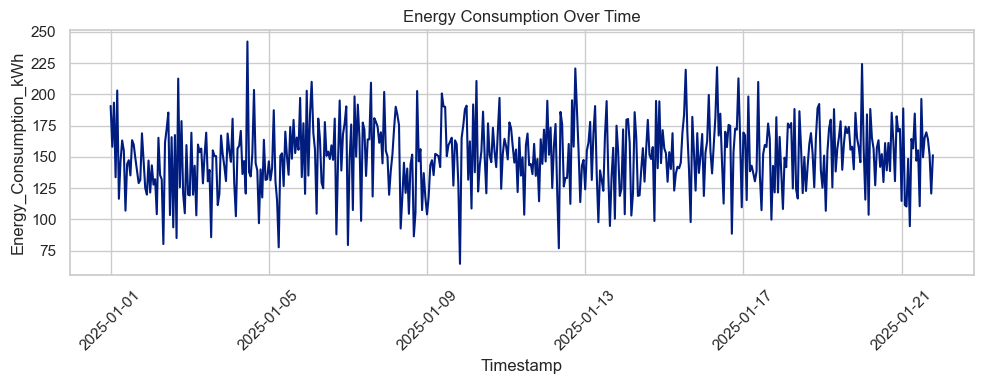

In [46]:
# Set plotting style
sns.set(style="whitegrid", palette="dark")

# 1. Energy Usage Over Time
plt.figure(figsize=(10, 4))
sns.lineplot(data=energy_df, x='Timestamp', y='Energy_Consumption_kWh')
plt.title("Energy Consumption Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

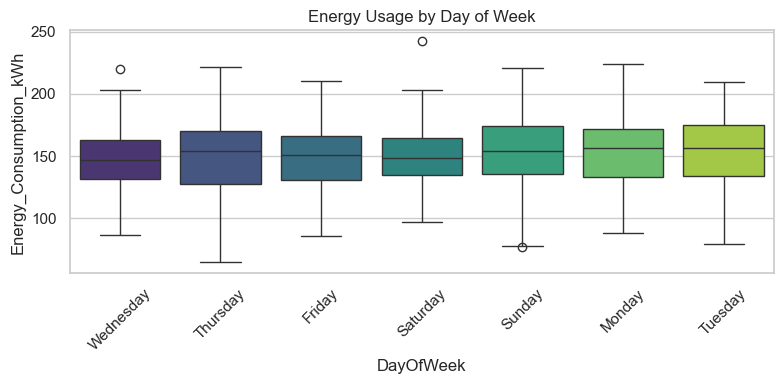

In [71]:
# 2. Boxplot: Energy Usage by Day of Week
plt.figure(figsize=(8, 4))
sns.boxplot(data=energy_df, x='DayOfWeek', y='Energy_Consumption_kWh', palette= 'viridis')
plt.title("Energy Usage by Day of Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

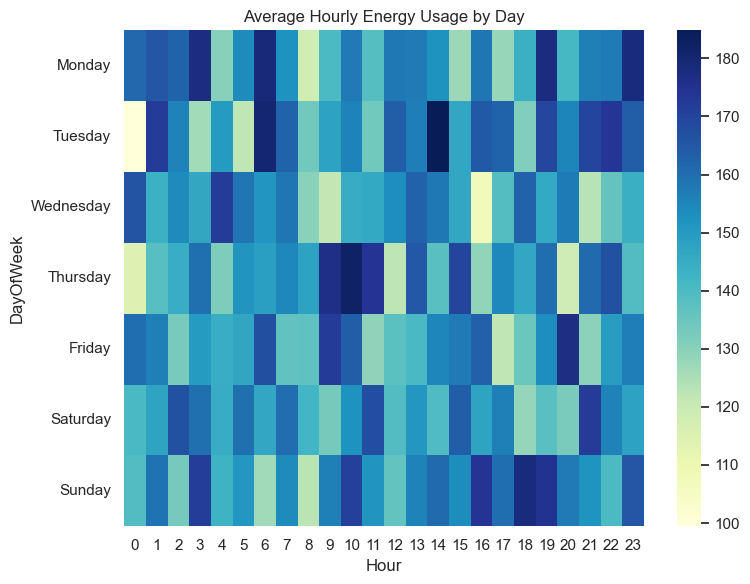

In [67]:
# 3. Heatmap: Hourly Energy Usage by Day
pivot_table = energy_df.pivot_table(index='DayOfWeek', columns='Hour', values='Energy_Consumption_kWh', aggfunc='mean')
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table = pivot_table.reindex(ordered_days)
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, cmap='YlGnBu')
plt.title("Average Hourly Energy Usage by Day")
plt.tight_layout()
plt.show()

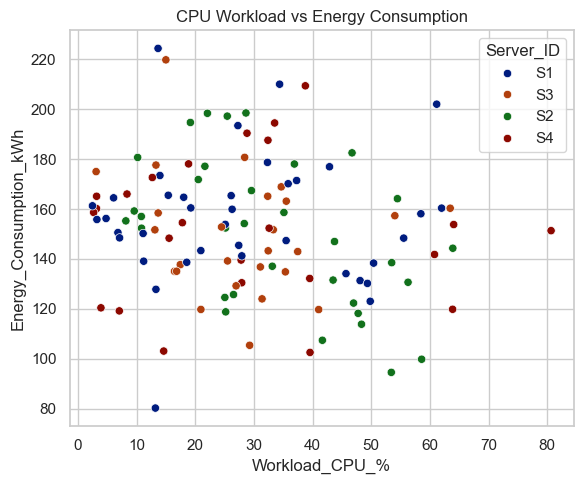

In [68]:
# 4. Scatter Plot: CPU Workload vs Energy Usage (merged)
merged_df = pd.merge(energy_df[['Timestamp', 'Server_ID', 'Energy_Consumption_kWh']],
                     performance_df[['Timestamp', 'Server_ID', 'Workload_CPU_%']],
                     on=['Timestamp', 'Server_ID'])

plt.figure(figsize=(6, 5))
sns.scatterplot(data=merged_df, x='Workload_CPU_%', y='Energy_Consumption_kWh', hue='Server_ID')
plt.title("CPU Workload vs Energy Consumption")
plt.tight_layout()
plt.show()

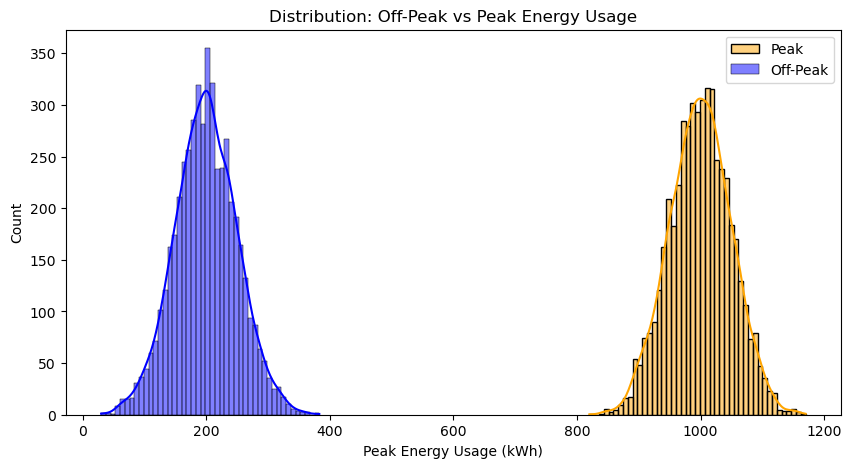

In [42]:
# 5. Peak vs Off-Peak Energy
plt.figure(figsize=(10, 5))
sns.histplot(energy_df['Peak Energy Usage (kWh)'], kde=True, label="Peak", color="orange")
sns.histplot(energy_df['Off-Peak Energy Usage (kWh)'], kde=True, label="Off-Peak", color="blue")
plt.title("Distribution: Off-Peak vs Peak Energy Usage")
plt.legend()
plt.show()

In [43]:
# 6. CPU Workload Distribution

import plotly.express as px

# Rename column for easier access
performance_df_clean = performance_df.rename(columns={"Workload (CPU %)": "CPU_Workload"})

# Create interactive histogram with percentage tooltip
fig = px.histogram(
    performance_df_clean,
    x="CPU_Workload",
    nbins=30,
    title="Distribution of CPU Workload (%)",
    color_discrete_sequence=["#636EFA"],  # dark blue
    marginal="rug",  # optional: adds small rug plot below
    opacity=0.8
)

# Update hover template to show percentage
fig.update_traces(
    hovertemplate="CPU %: %{x}<br>Count: %{y}<extra></extra>"
)

# Customize layout
fig.update_layout(
    xaxis_title="CPU Workload (%)",
    yaxis_title="Count",
    template="plotly_dark",
    bargap=0.1
)

fig.show()

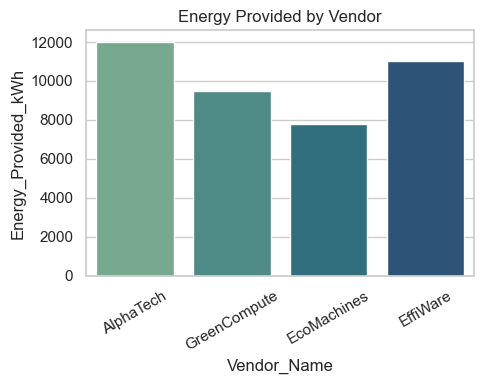

In [75]:
# 7. Energy Provided by Vendor
plt.figure(figsize=(5, 4))
sns.barplot(data=vendor_df, x='Vendor_Name', y='Energy_Provided_kWh', palette= 'crest')
plt.title("Energy Provided by Vendor")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [84]:
# 8. Vendor Rating Distribution with respect to vendor name

# Aggregate vendor ratings
vendor_rating_avg = vendor_df.groupby('Vendor_Name')['Vendor_Rating'].mean().reset_index()

# Create interactive pie chart
fig = px.pie(
    vendor_rating_avg,
    names='Vendor_Name',
    values='Vendor_Rating',
    title='Average Vendor Rating Distribution',
    color_discrete_sequence=px.colors.sequential.Viridis
)

# Optional: Customize hover template
fig.update_traces(
    textinfo='percent+label',
    hovertemplate='<b>%{label}</b><br>Rating Share: %{percent}<br>Avg Rating: %{value:.2f}'
)

# Show the chart
fig.show()
